# CS 195: Natural Language Processing
## Markov Models

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ericmanley/s26-CS195NLP/blob/main/F2_3_MarkovModels.ipynb)


## References

Markov chain on Wikipedia: https://en.wikipedia.org/wiki/Markov_chain

NLTK Book Chapter 2: Accessing Text Corpora and Lexical Resources https://www.nltk.org/book/ch02.html

What is ChatGPT Doing and Why Does it Work? By Stephen Wolfram: https://writings.stephenwolfram.com/2023/02/what-is-chatgpt-doing-and-why-does-it-work/
* This is a fascinating article that covers a lot of NLP topics. The opening motivates text generation with Markov-like descriptions.

[Chapter 3: N-gram Language Models](https://web.stanford.edu/~jurafsky/slp3/3.pdf). *Speech and Language Processing.* Daniel Jurafsky & James H. Martin

In [1]:
#you shouldn't need to do this in Colab, but I had to do it on my own machine
#in order to connect to the nltk service
# import nltk
# import ssl

# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context


## Andrey Andreyevich Markov

<div>
<img src="images/Andrei_Markov.jpg" width="200"/>
</div>

image source: https://en.wikipedia.org/wiki/Andrey_Markov

## Markov Chain

A **Markov Chain** describes a sequence of possible events and the probabilities of transitioning from one event state to another.

It can be applied to text - what is the probability that one word follows another?

Here is a diagram which corresponds to this text:

`"I code when I am happy. I am happy therefore I code."`

<div>
<img src="images/happy_markov_model.png"/>
</div>


## Shakespeare Example

*To be, or not to be, that is the question:
Whether 'tis nobler in the mind to suffer
The slings and arrows of outrageous fortune,
Or to take Arms against a Sea of troubles*

<div>
<img src="images/to_be_markov_model.png"/>
</div>

Transitions here are shown as frequencies instead of probabilities.



### Group Exercise

Suppose you are trying to predict the next word after seeing this sequence: *"to be , or not to"*

How can you use this model to predict the next word?

## Demo: Let's see how we can construct the model for this text

`"I code when I am happy. I am happy therefore I code."`

We want to represent this model in a data structure - could use 2D-list/matrix or a nested dictionary

Nested dictionary representation


`{
 'I': {'am': 2, 'code': 2},
 'code': {'.': 1, 'when': 1},
 'when': {'I': 1}
 'am': {'happy': 2},
 'happy': {'.': 1, 'therefore': 1},
 'therefore': {'I': 1},
 '.': {'I': 1},
}`


## Digression: Let's talk about those dictionaries


We could use a regular ol dictionary for this. But if you want to use a dictionary to count how many times you see a word, there's something that is kind of annoying about them:


In [2]:
regular_dict = {}

#...
# I saw "chicken", so let's add on to the "chicken" counter
regular_dict["chicken"] += 1

KeyError: 'chicken'

but it might not already be in the dictionary, so you have to do something like this:

In [3]:
if "chicken" in regular_dict:
    regular_dict["chicken"] += 1
else:
    regular_dict["chicken"] = 1
    
print(regular_dict["chicken"])

1


It would be great if it just assumed a missing value was 0 instead of throwing an error!

That's what a `defaultdict` does:

In [4]:
from collections import defaultdict

my_ddict = defaultdict(int) #we're going to put ints in there - this tells it to make 0 the default

my_ddict["chicken"] += 1

print(my_ddict["chicken"])

1


👍

## Training a Markov Model

Before we start training our model, let's make a list the **tokens** - all of the words, punctuation, and other things we want to be the states of the model. 

*(Future Warning: sometimes "tokens" can include parts of words, especially with LLMs - we'll discuss that later)* 

You can use the string `split` method for this:


In [5]:
text = "I code when I am happy . I am happy therefore I code . "
text_tokens = text.split()

print(text_tokens)

['I', 'code', 'when', 'I', 'am', 'happy', '.', 'I', 'am', 'happy', 'therefore', 'I', 'code', '.']


Now let's build the model using this list

In [6]:
from collections import defaultdict
from pprint import pprint

# this is our dictionary of dictionaries - 
# lambda: defaultdict(int) just means I want a bunch of defaultdicts of ints
transition_counts = defaultdict(lambda: defaultdict(int))

for idx in range(len(text_tokens)-1):
    current_token = text_tokens[idx]
    next_token = text_tokens[idx+1]
    transition_counts[current_token][next_token] += 1

    
pprint(transition_counts)

defaultdict(<function <lambda> at 0x120c9a5c0>,
            {'.': defaultdict(<class 'int'>, {'I': 1}),
             'I': defaultdict(<class 'int'>, {'code': 2, 'am': 2}),
             'am': defaultdict(<class 'int'>, {'happy': 2}),
             'code': defaultdict(<class 'int'>, {'when': 1, '.': 1}),
             'happy': defaultdict(<class 'int'>, {'.': 1, 'therefore': 1}),
             'therefore': defaultdict(<class 'int'>, {'I': 1}),
             'when': defaultdict(<class 'int'>, {'I': 1})})


## Let's make this into a function

I'll call the list of tokens **corpus** - which is another word for a body of text you use to train a model


In [7]:
def train_markov_model(corpus):
    # this is our dictionary of dictionaries - 
    # lambda: defaultdict(int) just means I want a bunch of defaultdicts of ints
    transition_counts = defaultdict(lambda: defaultdict(int))

    for idx in range(len(corpus)-1):
        current_token = corpus[idx]
        next_token = corpus[idx+1]
        transition_counts[current_token][next_token] += 1
    
    return transition_counts

to_be = "To be , or not to be , that is the question : Whether 'tis nobler in the mind to suffer The slings and arrows of outrageous fortune , Or to take Arms against a Sea of troubles ,"
to_be_tokens = to_be.lower().split() #convert to lowercase and break apart by spaces into a list
to_be_model = train_markov_model(to_be_tokens)

pprint(to_be_model)

defaultdict(<function train_markov_model.<locals>.<lambda> at 0x120c9ac00>,
            {"'tis": defaultdict(<class 'int'>, {'nobler': 1}),
             ',': defaultdict(<class 'int'>, {'or': 2, 'that': 1}),
             ':': defaultdict(<class 'int'>, {'whether': 1}),
             'a': defaultdict(<class 'int'>, {'sea': 1}),
             'against': defaultdict(<class 'int'>, {'a': 1}),
             'and': defaultdict(<class 'int'>, {'arrows': 1}),
             'arms': defaultdict(<class 'int'>, {'against': 1}),
             'arrows': defaultdict(<class 'int'>, {'of': 1}),
             'be': defaultdict(<class 'int'>, {',': 2}),
             'fortune': defaultdict(<class 'int'>, {',': 1}),
             'in': defaultdict(<class 'int'>, {'the': 1}),
             'is': defaultdict(<class 'int'>, {'the': 1}),
             'mind': defaultdict(<class 'int'>, {'to': 1}),
             'nobler': defaultdict(<class 'int'>, {'in': 1}),
             'not': defaultdict(<class 'int'>, {'to': 1}),
  

## How can we use this model?

We could now make a prediction about the next word in a sequence - like predictive text keyboards

<div>
<img src="images/predictive_text.png"/ width=300>
</div>

### How can we generate a good random *next* word after "to"

Notice this part of the model:

`
'to': defaultdict(<class 'int'>,
    {'be': 2,
    'suffer': 1,
    'take': 1}),
`

So when we see "to", we could
* always predict "be"
* randomly predict based on these possibilities
    * generate a random int between 1 and 4
        - 1: predict "be"
        - 2: predict "be"
        - 3: predict "suffer"
        - 4: predict "take"
    * words that appear after "to" more often a picked more often
    * generates more interesting text than always picking the highest-ranked choice

### coding it up

In [8]:
import random

def generate_random_next_word(current_word, transition_counts):
    #get the frequency of all words that come after current_word
    possible_words_counts = transition_counts[current_word]
    
    #count up the total of all words that come after current_word
    total_occurrences = sum(possible_words_counts.values())
    
    #we are going to select one occurence randomly
    random_num = random.randint(1,total_occurrences)

    #subtract words counts from our random number until we hit 0
    #this will hit more frequent words proportionally more often
    for word in possible_words_counts:
        random_num = random_num - possible_words_counts[word]
        if random_num <= 0:
            return word
        
print( generate_random_next_word("to",to_be_model)  )
print( generate_random_next_word("to",to_be_model)  )
print( generate_random_next_word("to",to_be_model)  )
print( generate_random_next_word("to",to_be_model)  )
print( generate_random_next_word("to",to_be_model)  )
print( generate_random_next_word("to",to_be_model)  )
print( generate_random_next_word("to",to_be_model)  )
print( generate_random_next_word("to",to_be_model)  )
print( generate_random_next_word("to",to_be_model)  )
print( generate_random_next_word("to",to_be_model)  )

be
be
suffer
be
suffer
suffer
suffer
take
take
take


## Generating a whole bunch of text

Now we can write a function that successively calls `generate_random_next_word` to generate a whole sequence of words

In [9]:
def generate_text(num,start_word,model):
    #a running string to build on with random words
    markov_text = start_word + " "
    curr_word = start_word

    #add num random words onto our running string
    for n in range(num):
        curr_word = generate_random_next_word(curr_word,model)
        markov_text += curr_word 
        markov_text += " "

    return markov_text

print( generate_text(30, "to", to_be_model) )

to take arms against a sea of outrageous fortune , or not to be , or to take arms against a sea of outrageous fortune , that is the mind to 


This text superficially looks like the training text, but it is nonsense.

Two ways you can improve it:
1. Train it with more text
2. Use more than one word to predict the next word - needs to see lots of examples

## Putting it all together


In [10]:
from nltk.corpus import gutenberg
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
import random
from pprint import pformat

class MarkovModel:
    
    def __init__(self):
        # empty nested dictionary mapping words to words to ints
        self.transition_counts = defaultdict(lambda: defaultdict(int))
        
    def train(self,corpus):
        #loop through each word in the corpus record the next word
        #in its frequency dictionary
        for idx in range(len(corpus)-1):
            current_token = corpus[idx]
            next_token = corpus[idx+1]
            self.transition_counts[current_token][next_token] += 1
            
    def generate_random_next_word(self,current_word):
        #get the frequency of all words that come after current_word
        possible_words_counts = self.transition_counts[current_word]
        #count up the total of all words that come after current_word
        total_occurrences = sum(possible_words_counts.values())

        #we are going to select one occurence randomly
        random_num = random.randint(1,total_occurrences)

        #subtract words counts from our random number until we hit 0
        #this will hit more frequent words proportionally more often
        for word in possible_words_counts:
            random_num = random_num - possible_words_counts[word]
            if random_num <= 0:
                return word
           
    def generate_text(self,num=100,start_word = "I"):
        #a running string to build on with random words
        markov_text = start_word + " "
        curr_word = start_word
        
        #add num random words onto our running string
        for n in range(num):
            curr_word = self.generate_random_next_word(curr_word)
            markov_text += curr_word 
            markov_text += " "
            
        return markov_text
    
    def __str__(self):
        # convert defaultdicts to dicts and format using the pprint formatter
        return pformat({key:dict(self.transition_counts[key]) for key in self.transition_counts})
    
    def visualize(self,probabilities=False,layout=nx.kamada_kawai_layout):
        # use this method to generate visualizations of small models
        # it will take too long on large texts - don't do it!
        G = nx.DiGraph()
        
        if probabilities:
            transition_probabilities = defaultdict(dict)
            for current_word, next_words in self.transition_counts.items():
                total_occurrences = sum(next_words.values())
                for next_word, count in next_words.items():
                    transition_probabilities[current_word][next_word] = count / total_occurrences
                    
            for current_word, next_words in transition_probabilities.items():
                for next_word, probability in next_words.items():
                    G.add_edge(current_word, next_word, weight=probability)
        else:
            for current_word, next_words in self.transition_counts.items():
                for next_word, count in next_words.items():
                    G.add_edge(current_word, next_word, weight=count)

        pos = layout(G)
        edge_labels = {edge: f"{G.edges[edge]['weight']}" for edge in G.edges()}
        nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=10)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

        plt.title("Markov Model Visualization")
        plt.show()
        
to_be = "To be , or not to be , that is the question : Whether 'tis nobler in the mind to suffer The slings and arrows of outrageous fortune , Or to take Arms against a Sea of troubles"
to_be_tokens = to_be.lower().split() #convert to lowercase and break apart by spaces into a list
to_be_model = MarkovModel()
to_be_model.train(to_be_tokens)

print(to_be_model)

{"'tis": {'nobler': 1},
 ',': {'or': 2, 'that': 1},
 ':': {'whether': 1},
 'a': {'sea': 1},
 'against': {'a': 1},
 'and': {'arrows': 1},
 'arms': {'against': 1},
 'arrows': {'of': 1},
 'be': {',': 2},
 'fortune': {',': 1},
 'in': {'the': 1},
 'is': {'the': 1},
 'mind': {'to': 1},
 'nobler': {'in': 1},
 'not': {'to': 1},
 'of': {'outrageous': 1, 'troubles': 1},
 'or': {'not': 1, 'to': 1},
 'outrageous': {'fortune': 1},
 'question': {':': 1},
 'sea': {'of': 1},
 'slings': {'and': 1},
 'suffer': {'the': 1},
 'take': {'arms': 1},
 'that': {'is': 1},
 'the': {'mind': 1, 'question': 1, 'slings': 1},
 'to': {'be': 2, 'suffer': 1, 'take': 1},
 'whether': {"'tis": 1}}


## Downloading a corpus from the `nltk` library

`nltk` is the Natural Language Toolkit - lots of great corpora, algorithms, and other resources

They have a sample of free books from [Project Gutenberg](https://www.gutenberg.org/)

You can find a list of the available corpora here: https://www.nltk.org/nltk_data/

In [11]:
import nltk
nltk.download('gutenberg') # you probably only need to do this once
print( nltk.corpus.gutenberg.fileids() )

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


[nltk_data] Error loading gutenberg: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


Let's try Moby Dick

In [12]:
from nltk.corpus import gutenberg
moby_dick = gutenberg.words('melville-moby_dick.txt')
print(moby_dick) 

['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', ...]


This will only print truncated output, but it's the whole book!

This is a list of tokens - exactly what we need!

In [13]:
model = MarkovModel()
model.train(moby_dick)

print(str(model)[:10000] )
#print( model ) #uncomment to print the whole model

{'!': {'"': 19,
       "'": 4,
       '(': 6,
       '2ND': 1,
       '4TH': 1,
       'A': 6,
       'ALL': 3,
       'AZORE': 1,
       'Accursed': 1,
       'Adieu': 1,
       'Adverse': 1,
       'After': 1,
       'Again': 1,
       'Ah': 1,
       'Ahab': 3,
       'Ain': 1,
       'All': 5,
       'Aloft': 2,
       'An': 1,
       'And': 16,
       'Angels': 1,
       'Another': 1,
       'Are': 2,
       'Away': 3,
       'Aye': 5,
       'BELFAST': 1,
       'Bang': 1,
       'Beach': 1,
       'Bear': 2,
       'Begone': 1,
       'Besides': 1,
       'Bestow': 1,
       'Beware': 4,
       'Bible': 1,
       'Bildad': 1,
       'Blang': 1,
       'Blind': 1,
       'Blood': 1,
       'Boat': 1,
       'Boats': 1,
       'Bulkington': 1,
       'Burst': 1,
       'But': 24,
       'By': 3,
       'CHAPTER': 17,
       'Call': 2,
       'Can': 2,
       'Cant': 1,
       'Capting': 1,
       'Careful': 1,
       'Caught': 1,
       'Coffin': 1,
       'Cold': 1,
       'Come'

In [14]:
print( model.generate_text(100,"I") )

I ever cullest Thy country , " There ' st all his chief - mast - fishery . Gurry , I pound that his stern boat wore it . I am I was a moment , sluggish corpse in England ; but the whale as hone can it so be incorporated into that morning ; when I could not a Lima now have furnished with Fedallah gazed over the human mothers of his boots ." -- the Malays ; nevertheless , seemed to wondrous whale in most old rounds , ain ' s unharming sharks , ye will soon as the 


## Group Exercise

Load some additional books and train the model with more than one book
* call `model.train` multiple times

What kind of text does your model generate?

## Group Exercise

Check out the other examples of corpora here: https://www.nltk.org/book/ch02.html

Can you train and generate other kinds of text?

## Group Exercise

Sketch out what this data structure would look like if you wanted to use bigrams (two consecutive words) to predict the next word.

This is called a **2nd-order Markov Model**

For reference, here's what the 1st-order Markov Model data structure looks like:

`"To be , or not to be , that is the question : Whether 'tis nobler in the mind to suffer The slings and arrows of outrageous fortune , Or to take Arms against a Sea of troubles"`

`{"'tis": {'nobler': 1},
 ',': {'or': 2, 'that': 1},
 ':': {'whether': 1},
 'a': {'sea': 1},
 'against': {'a': 1},
 'and': {'arrows': 1},
 'arms': {'against': 1},
 'arrows': {'of': 1},
 'be': {',': 2},
 'fortune': {',': 1},
 'in': {'the': 1},
 'is': {'the': 1},
 'mind': {'to': 1},
 'nobler': {'in': 1},
 'not': {'to': 1},
 'of': {'outrageous': 1, 'troubles': 1},
 'or': {'not': 1, 'to': 1},
 'outrageous': {'fortune': 1},
 'question': {':': 1},
 'sea': {'of': 1},
 'slings': {'and': 1},
 'suffer': {'the': 1},
 'take': {'arms': 1},
 'that': {'is': 1},
 'the': {'mind': 1, 'question': 1, 'slings': 1},
 'to': {'be': 2, 'suffer': 1, 'take': 1},
 'whether': {"'tis": 1}}`


## Applied Exploration

Enhance the `MarkovModel` class to take in a parameter that allows it to be a 1st, 2nd, 3rd, etc. order model.
* Train it with a large corpus (maybe more than one)
* Give examples of the text generated at each order
* Do you run into difficulties with some pairs not being present? How should we deal with those - write down some ideas.



## Example of using the visualizer

['to', 'be', ',', 'or', 'not', 'to', 'be', ',', 'that', 'is', 'the', 'question', ':', 'whether', "'tis", 'nobler', 'in', 'the', 'mind', 'to', 'suffer', 'the', 'slings', 'and', 'arrows', 'of', 'outrageous', 'fortune', ',', 'or', 'to', 'take', 'arms', 'against', 'a', 'sea', 'of', 'troubles']


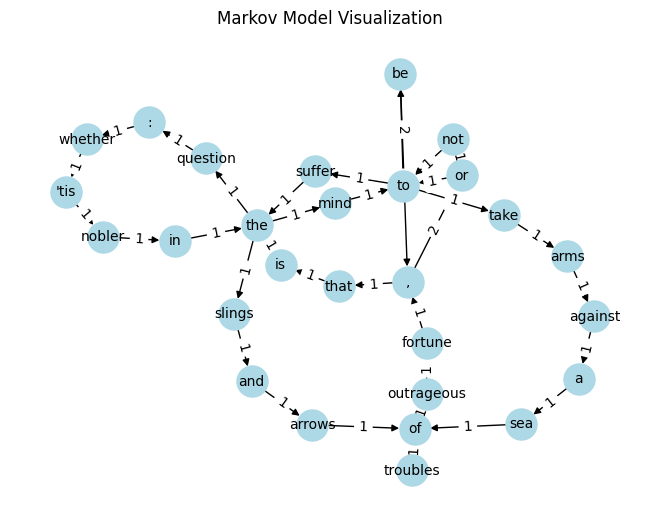

In [15]:
to_be = "To be , or not to be , that is the question : Whether 'tis nobler in the mind to suffer The slings and arrows of outrageous fortune , Or to take Arms against a Sea of troubles"
to_be_tokens = to_be.lower().split() #convert to lowercase and break apart by spaces into a list
print(to_be_tokens)

to_be_model = MarkovModel()
to_be_model.train(to_be_tokens)
to_be_model.visualize(probabilities=False)